In [1]:
# !pip install patsy
# ! pip install statsmodels
# !pip install scikit-learn
import matplotlib.pyplot as plt
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
import torch
import numpy as np
from sklearn.metrics import r2_score
from heteroscedastic import BetaGaussianMLP, BetaGaussianLM, _radius

In [2]:
cancer_dataset = sm.datasets.cancer.load_pandas()

In [3]:
y, X = dmatrices('cancer ~ population', data=cancer_dataset.data, return_type='dataframe')

In [4]:
# X

In [5]:
# plt.scatter(cancer_dataset.exog, cancer_dataset.endog, marker='.')

In [6]:
# # Statistically confirm that the data is heteroscedastic
# ols = sm.OLS(y, X)
# ols_result = ols.fit()
# ols_result.mse_model
# # residuals of a Lin Model are dependent on X
# # plt.scatter(X.population, ols_result.resid)
# # statistical tests confirm this:
# het_white(ols_result.resid, X)
# het_breuschpagan(ols_result.resid, X, robust=False)

In [7]:
# Fitting models

In [8]:
torch.set_default_dtype(torch.double)

In [9]:
X_torch = torch.from_numpy(X.to_numpy())[:, 1].unsqueeze(-1)
y_torch = torch.from_numpy(y.to_numpy()).squeeze()

In [10]:
p = np.random.permutation(len(X_torch))
X_torch = X_torch[p]
y_torch = y_torch[p]

In [11]:
# leave out x% of the points at the end: extrapolate
n_test = int(.5 * len(X_torch))
X_test, X_train = X_torch[-n_test:], X_torch[:-n_test]
y_test, y_train = y_torch[-n_test:], y_torch[:-n_test]

In [12]:
# normalize inputs
mu = X_train.mean()
std = torch.norm(X_train - mu)

In [13]:
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std
X_torch = (X_torch - mu) / std

In [14]:
min(X_torch)

tensor([-0.0642])

In [15]:
# def save_for_plot(model):
#     alpha = model.alpha
#     model.eval()
    
#     t = torch.linspace(X_torch.min(), X_torch.max() + .1, len(X_torch)).unsqueeze(-1)
#     with torch.no_grad():
    
#         y_pred, sigma_sq = model(t)
#         std_pred = sigma_sq.sqrt()
    
#     t = t.squeeze().numpy()
#     y_pred = y_pred.squeeze().numpy()
#     std_pred = std_pred.squeeze().numpy()

#     if alpha == 1:
#         # 95% confidence interval.
#         a = 2*std_pred
#     else:
#         # 100% confidence interval.
#         R = _radius(1, alpha)
#         tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
#         a = np.sqrt(-2 * tau * std_pred**2)
        
#     return t, y_pred, a
    

# def plot_model(t, y_pred, a, ax, which="support", fill_color='C0'):
#     ax.plot(t, y_pred, color='C0', label="predicted mean")

#     ax.fill_between(t,
#                     y_pred - a,
#                     y_pred + a,
#                     alpha=0.2, color=fill_color, label="predicted {}".format(which))
       
#     # Plot the truth
#     ax.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='C1', label='train')
#     ax.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')

#     ax.set_ylim(-10, 370)
#     ax.set_xlim(None, t[-1])

# def save_for_conf(model):
#     alpha = model.alpha
#     model.eval()
    
#     # t_test = torch.linspace(X_test.min(), X_test.max() + .1, len(X_test)).unsqueeze(-1)
#     with torch.no_grad():
    
#         y_pred_test, sigma_sq_test = model(X_test)
#         std_pred_test = sigma_sq_test.sqrt()
    
#     # t_test = t_test.squeeze().numpy()
#     y_pred_test = y_pred_test.squeeze().numpy()
#     std_pred_test = std_pred_test.squeeze().numpy()

#     if alpha == 1:
#         # 95% confidence interval.
#         a_test = 2*std_pred_test
#     else:
#         # 100% confidence interval.
#         R_test = _radius(1, alpha)
#         tau_test = (-R_test**2)/2 * (std_pred_test**2) ** (-(alpha-1) / (alpha+1))
#         a_test = np.sqrt(-2 * tau_test * std_pred_test**2)

#     return y_test, y_pred_test, a_test, X_test.squeeze().numpy()

In [16]:
def save_for_plot(model):
    alpha = model.alpha
    model.eval()
    
    t = torch.linspace(X_torch.min(), X_torch.max() + .1, 100).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred, sigma_sq = model(t)
        std_pred = sigma_sq.sqrt()
    
    t = t.squeeze().numpy()
    y_pred = y_pred.squeeze().numpy()
    std_pred = std_pred.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a = 2*std_pred
    else:
        # 100% confidence interval.
        R = _radius(1, alpha)
        tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
        a = np.sqrt(-2 * tau * std_pred**2)
        
    return t, y_pred, a

def save_for_conf(model):
    alpha = model.alpha
    model.eval()
    
    t_test = torch.linspace(X_test.min(), X_test.max() + .1, 100).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred_test, sigma_sq_test = model(X_test)
        std_pred_test = sigma_sq_test.sqrt()
    
    # t_test = t_test.squeeze().numpy()
    y_pred_test = y_pred_test.squeeze().numpy()
    std_pred_test = std_pred_test.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a_test = 2*std_pred_test
    else:
        # 100% confidence interval.
        R_test = _radius(1, alpha)
        tau_test = (-R_test**2)/2 * (std_pred_test**2) ** (-(alpha-1) / (alpha+1))
        a_test = np.sqrt(-2 * tau_test * std_pred_test**2)

    return y_test, y_pred_test, a_test, X_test.squeeze().numpy()

def plot_model(t, y_pred, a, ax, res_conf, which="support", fill_color='C0', fill_color1='C0',):
    ax.plot(t, y_pred, color='C0', label="predicted mean")

    ax.fill_between(t,
                    y_pred - a,
                    y_pred + a,
                    alpha=0.2, color=fill_color, label="predicted {}".format(which))
    ax.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='crimson', label='train',alpha=0.6, s=13)

    preds = res_conf[1][:, None]
    sigmas = res_conf[2][:, None]/2
    trues = res_conf[0][:, None].numpy()
    x = res_conf[3][:, None]
    
    pred_test = preds[100:]
    true_test = trues[100:]
    sigma_test = sigmas[100:]
    x_test = x[100:]
    
    pred_cal = preds[:100]
    true_cal = trues[:100]
    sigma_cal = sigmas[:100]
    x_cal = x[:100]
    
    n_test = true_test.shape[0]
    n_cal = true_cal.shape[0]
    
    # scores
    
    cal_scores = np.abs(pred_cal-true_cal)/sigma_cal
    test_scores = np.abs(pred_test-true_test)/sigma_test
    
    alpha = 0.1
    q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
    qhat = np.quantile(cal_scores, q_level, method = 'higher') # check quantile method
    
    # test predictions
    test_intervals = np.zeros((n_test,2))
    test_intervals[:,0:1] = pred_test-qhat*sigma_test
    test_intervals[:,1:] = pred_test+qhat*sigma_test
    
    coverage = ((true_test<=test_intervals[:,1:]) & (true_test>=test_intervals[:,0:1])).sum()/n_test

    df = pd.DataFrame({'x':x_test[:,0],
                       'lower': test_intervals[:,0],
                       'upper':test_intervals[:,1]})
    
    df.sort_values(by = 'x', inplace = True)
    ax.fill_between(df['x'],
                    df['lower'],
                    df['upper'],
                    alpha=0.2, color=fill_color1, label='calibrated test')

    # Plot the truth
    ax.scatter(x_cal, true_cal, marker='x', color='darkgreen', label='cal', alpha=0.6, s=13)
    ax.scatter(x_test, true_test, marker='*', color='royalblue', label='test', alpha=0.6, s=13)
    ax.set_ylim(-10, 350)
    ax.set_xlim(None, df['x'].to_numpy()[-1]) # min(df['x'].to_numpy())



In [17]:
# baseline

torch.manual_seed(21)
bl_model = BetaGaussianLM(input_size=1, uncertainty=False, heteroscedastic=False, alpha=None)
optimizer = torch.optim.LBFGS(bl_model.parameters(), lr=.01, max_iter=100)

n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    
    def closure():
        optimizer.zero_grad()
        bl_model.train()
        loss = bl_model.loss(X_train, y_train)
        loss.backward()
        return loss

    optimizer.step(closure)

# evaluate R^2
y_pred_train = bl_model.predict(X_train).detach().numpy()
y_pred_test = bl_model.predict(X_test).detach().numpy()
print("R2 train {:.3f} test {:.3f}".format(
    r2_score(y_pred_train, y_train.numpy()),
    r2_score(y_pred_test, y_test.numpy())))
    
print("w", bl_model.pred_y.weight.data, "b", bl_model.pred_y.bias.data)

R2 train 0.942 test 0.923
w tensor([[701.5868]]) b tensor([44.2185])


In [18]:
# try lbfgs

old_loss = np.inf

n_epochs = 1000

results = []
res_conf= []

for j, alpha in enumerate([1, 4/3, 1.5, 2]):
    torch.manual_seed(21)
    model = BetaGaussianLM(input_size=1, uncertainty=True, heteroscedastic=True, alpha=alpha)
    
    model.pred_y.weight.data[:] = bl_model.pred_y.weight
    model.pred_y.bias.data[:] = bl_model.pred_y.bias
    optimizer = torch.optim.LBFGS(model.parameters(), lr=.01, line_search_fn='strong_wolfe', max_iter=100)
    
    for epoch in range(n_epochs):
        
        def closure():
            optimizer.zero_grad()
            model.train()
            loss = model.loss(X_train, y_train)
            loss.backward()
            return loss
        
        optimizer.step(closure)
            
    # evaluate R^2
    model.eval()
    y_pred_train = model.predict(X_train).detach().numpy()
    y_pred_test = model.predict(X_test).detach().numpy()
    r2 = "R2 train {:.3f} test {:.3f}".format(
        r2_score(y_pred_train, y_train.numpy()),
        r2_score(y_pred_test, y_test.numpy()))
    
    print(alpha, r2)    
    results.append((alpha, save_for_plot(model), r2))
    res_conf.append(save_for_conf(model))
    # np.savetxt(f"cancer_{alpha}_{r2}.csv", save_for_conf(model), delimiter=",")

1 R2 train 0.924 test 0.928
1.3333333333333333 R2 train 0.924 test 0.928
1.5 R2 train 0.924 test 0.928
2 R2 train 0.927 test 0.928


In [19]:
# y_pred_test

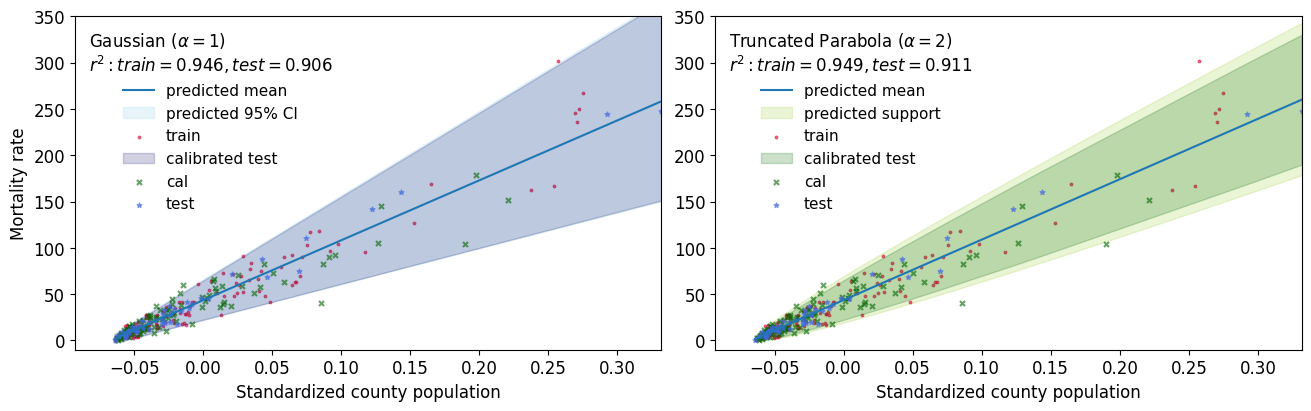

In [27]:
fig, (ax_gauss, ax_tp) = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True)

plt.rcParams['legend.title_fontsize'] = 12
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plot_model(*results[0][1], ax_gauss, res_conf[0], "95% CI", fill_color='skyblue', fill_color1='midnightblue' )
plot_model(*results[3][1], ax_tp, res_conf[3], "support", fill_color='yellowgreen', fill_color1='darkgreen')
# plot_model(*results[0][1], ax_gauss,  "95% CI", fill_color='C0', )
# plot_model(*results[3][1], ax_tp,  "support", fill_color='C8')
ax_gauss.legend(title="Gaussian ($\\alpha=1$)\n$r^2: train = 0.946, test = 0.906$", fontsize=11)
ax_tp.legend(title="Truncated Parabola ($\\alpha=2$)\n$r^2: train = 0.949, test = 0.911 $", fontsize=11)
ax_gauss.set_ylabel("Mortality rate", fontsize=12)
ax_gauss.set_xlabel("Standardized county population", fontsize=12)
ax_tp.set_xlabel("Standardized county population", fontsize=12)
plt.savefig("heteroscedastic.pdf")

In [21]:
preds = res_conf[0][1][:, None]
sigmas = res_conf[0][2][:, None]/2
trues = res_conf[0][0][:, None].numpy()
x = res_conf[0][3][:, None]

pred_test = preds[100:]
true_test = trues[100:]
sigma_test = sigmas[100:]
x_test = x[100:]

pred_cal = preds[:100]
true_cal = trues[:100]
sigma_cal = sigmas[:100]
x_cal = x[:100]

n_test = true_test.shape[0]
n_cal = true_cal.shape[0]

# scores
cal_scores = np.abs(pred_cal-true_cal)/sigma_cal
test_scores = np.abs(pred_test-true_test)/sigma_test

alpha = 0.1
q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
qhat = np.quantile(cal_scores, q_level, method = 'higher') # check quantile method

# test predictions
test_intervals = np.zeros((n_test,2))
test_intervals[:,0:1] = pred_test-qhat*sigma_test
test_intervals[:,1:] = pred_test+qhat*sigma_test

coverage = ((true_test<=test_intervals[:,1:]) & (true_test>=test_intervals[:,0:1])).sum()/n_test

# print(f'Coverage:{coverage}')
widths = test_intervals[:,1]-test_intervals[:,0]
avg_width = widths.mean()

# plt.boxplot(widths)
# print(f'Avg width: {avg_width}')


Coverage:1.0
Coverage FY:1.0
Avg width: 38.53942282764344
Avg width FY: 34.571262906510036


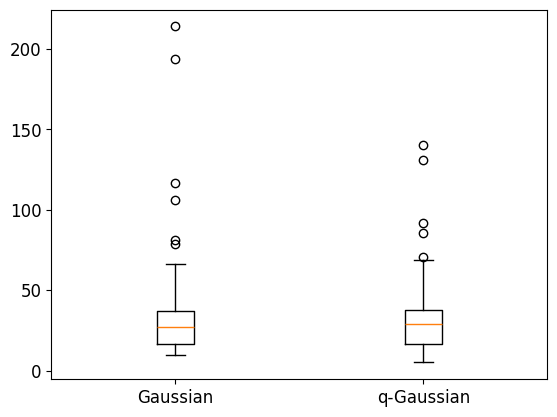

In [25]:
preds_fy = res_conf[3][1][:, None]
sigmas_fy = res_conf[3][2][:, None]/2
trues_fy = res_conf[3][0][:, None].numpy()
x_fy = res_conf[3][3][:, None]

pred_test_fy = preds_fy[100:]
true_test_fy = trues_fy[100:]
sigma_test_fy = sigmas_fy[100:]
x_test_fy = x_fy[100:]

pred_cal_fy = preds_fy[:100]
true_cal_fy = trues_fy[:100]
sigma_cal_fy = sigmas_fy[:100]
x_cal_fy = x_fy[:100]

n_test_fy = true_test_fy.shape[0]
n_cal_fy = true_cal_fy.shape[0]

# scores
cal_scores_fy = np.abs(pred_cal_fy-true_cal_fy)/sigma_cal_fy
test_scores_fy = np.abs(pred_test_fy-true_test_fy)/sigma_test_fy

alpha_fy = 0.1
q_level_fy = np.ceil((n_cal_fy+1)*(1-alpha_fy))/n_cal_fy
qhat_fy = np.quantile(cal_scores_fy, q_level_fy, method = 'higher') # check quantile method

# test predictions
test_intervals_fy = np.zeros((n_test_fy,2))
test_intervals_fy[:,0:1] = pred_test_fy-qhat_fy*sigma_test_fy
test_intervals_fy[:,1:] = pred_test_fy+qhat_fy*sigma_test_fy

coverage_fy = ((true_test_fy<=test_intervals_fy[:,1:]) & (true_test_fy>=test_intervals_fy[:,0:1])).sum()/n_test_fy


print(f'Coverage:{coverage}')
widths = test_intervals[:,1]-test_intervals[:,0]
avg_width = widths.mean()

print(f'Coverage FY:{coverage_fy}')
widths_fy = test_intervals_fy[:,1]-test_intervals_fy[:,0]
avg_width_fy = widths_fy.mean()

plt.boxplot([widths, widths_fy], labels=('Gaussian', 'q-Gaussian'))
print(f'Avg width: {avg_width}')
print(f'Avg width FY: {avg_width_fy}')
plt.savefig("boxes_cancer.pdf")

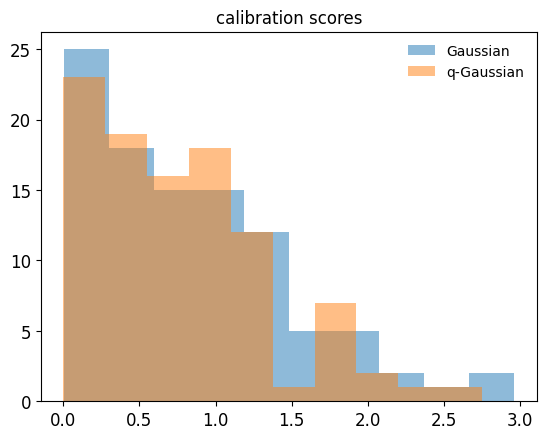

In [26]:
plt.hist(cal_scores, alpha=0.5, label='Gaussian' )
plt.hist(cal_scores_fy, alpha=0.5, label='q-Gaussian' )
plt.legend(loc='upper right')
plt.title('calibration scores')
plt.savefig("hist_cancer.pdf")

In [24]:
# df = pd.DataFrame({'x':x_test[:,0],
#                    'lower': test_intervals[:,0],
#                    'upper':test_intervals[:,1]})

# df.sort_values(by = 'x', inplace = True)
# plt.fill_between(df['x'],
#                 df['lower'],
#                 df['upper'],
#                 alpha=0.2, color='blue')
   
# # Plot the truth
# plt.scatter(x_cal, true_cal, marker='.', color='C1', label='cal')
# plt.scatter(x_test, true_test, marker='x', color='C2', label='test')
# plt.legend()